In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from astropy.io import fits
from scipy import stats
from sklearn.utils import check_random_state

· From here

https://stingray.readthedocs.io/en/latest/notebooks/Simulator/Concepts/PowerLaw%20Spectrum.html

and following this paper:https://ui.adsabs.harvard.edu/abs/1995A%26A...300..707T/abstract

 On generating power law noise. Timmer and Koenig 1995
 
 https://ui.adsabs.harvard.edu/abs/1992ApJ...400..138D/abstract
 
 
 All red noise simulationsin this paper were produced by an algorithm detailed in [30], which randomizes both phase andamplitude of an underlying power law spectrum and then inverse Fourier transforms it intothe time domain to create light curves. Our procedure for producing simulated light curves isas follows: first, a light curve is produced from a PSD with a specific power law slope evenlysampled at half the shortest observed time sampling interval; we then re-sample the light curveat the exact sampling times used during the specific night that we are simulating; finally, sincethe simulation has an arbitrary flux scale, we scale the light curves to have the same mean andstandard deviation as that night.
 Testing for periodicities in near-IR light curves ofSgr A
 
 
 https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation

In [3]:
cp ../../u9712005/*18.npy .

In [4]:
############
name = 'u18'
mjd = np.load('mjd'+name+'.npy')
mag = np.load('mag'+name+'.npy')
dmag = np.load('dmag'+name+'.npy')
obnames = np.load('obnames'+name+'.npy')
time = np.load('time'+name+'.npy')



NameError: name 'np' is not defined

In [5]:
def simulate(B,lengthlc):

    N = lengthlc

    # Define frequencies from 0 to 2*pi
    w = np.linspace(0.001,2*np.pi,N)

    # Draw two set of 'N' guassian distributed numbers
    a1 = np.random.normal(size=N)
    a2 = np.random.normal(size=N)

    # Multiply by (1/w)^B to get real and imaginary parts
    real = a1 * np.power((1/w),B/2)
    imaginary = a2 * np.power((1/w),B/2)

    # Form complex numbers corresponding to each frequency
    f = [complex(r, i) for r,i in zip(real,imaginary)]

    # Obtain real valued time series
    f_conj = np.conjugate(np.array(f))

    # Obtain time series
    f_inv = np.fft.ifft(f_conj)

    return f_inv

# From astro-ML

In [6]:
def generate_power_law(N, dt, beta, generate_complex=False,random_state=None):
    """Generate a power-law light curve
    This uses the method from Timmer & Koenig [1]_
    Parameters
    ----------
    N : integer
        Number of equal-spaced time steps to generate
    dt : float
        Spacing between time-steps
    beta : float
        Power-law index.  The spectrum will be (1 / f)^beta
    generate_complex : boolean (optional)
        if True, generate a complex time series rather than a real time series

    Returns
    -------
    x : ndarray
        the length-N
    References
    ----------
    .. [1] Timmer, J. & Koenig, M. On Generating Power Law Noise. A&A 300:707
    """
    random_state = check_random_state(random_state)
    dt = float(dt)
    N = int(N)

    Npos = int(N / 2)
    Nneg = int((N - 1) / 2)
    domega = (2 * np.pi / dt / N)

    if generate_complex:
        omega = domega * np.fft.ifftshift(np.arange(N) - int(N / 2))
    else:
        omega = domega * np.arange(Npos + 1)

    x_fft = np.zeros(len(omega), dtype=complex)
    x_fft.real[1:] = random_state.normal(0, 1, len(omega) - 1)
    x_fft.imag[1:] = random_state.normal(0, 1, len(omega) - 1)

    x_fft[1:] *= (1. / omega[1:]) ** (0.5 * beta)
    x_fft[1:] *= (1. / np.sqrt(2))

    # by symmetry, the Nyquist frequency is real if x is real
    if (not generate_complex) and (N % 2 == 0):
        x_fft.imag[-1] = 0

    if generate_complex:
        x = np.fft.ifft(x_fft)
    else:
        x = np.fft.irfft(x_fft, N)

    return x

In [7]:
dt2 = 0.00694444
newmjd = np.arange(mjd.min(),mjd.max()+1,dt2)

NameError: name 'np' is not defined

In [8]:
mjd

NameError: name 'mjd' is not defined

In [9]:
closest = [newmjd[np.abs(i-newmjd).argmin()] for i in mjd]
for i in mjd:
    c = newmjd[np.abs(i-newmjd).argmin()]
    d = np.abs(i-c)
    print(c,i,d)

NameError: name 'mjd' is not defined

In [10]:
f = simulate(2,1000)
#plt.scatter(mjd,np.real(f))
#plt.plot(mjd,np.real(f))
mag2 = np.real(f)[np.argsort(mjd)]
dmag2 = dmag[np.argsort(mjd)]

mjd2 =np.sort(mjd)


plt.plot(mjd2,np.real(f))

plt.xlabel('Time')
plt.ylabel('')
plt.title('Recovered LightCurve with B=2')

NameError: name 'np' is not defined

# Z trammnsformmm

In plain English, to transform a variable to have a desired mean and a desired standard deviation,simply take the Z-transform of the original variable, multiply it by the desired standard deviation,and then add the desired mean

In [162]:
print(np.mean(mag))
print(np.std(mag))

17.564875
0.06353712708218053


In [175]:
fz = stats.zscore(np.real(f))*np.std(mag)+np.mean(mag)
print(fz.mean())
print(fz.std())

17.564875
0.06353712708218058


In [180]:
stats.zscore(np.real(f))[0:5]
[(i-np.mean(np.real(f)))/np.std(np.real(f)) for i in np.real(f)][0:5]

[-1.7634197481715983,
 -1.3073621150676795,
 -1.9202023015242589,
 -1.4715993795262912,
 -1.3208407499612054]

In [185]:
muerror,sigmaerror = np.mean(dmag), np.std(dmag)
s = np.random.normal(muerror, sigmaerror, 1000)

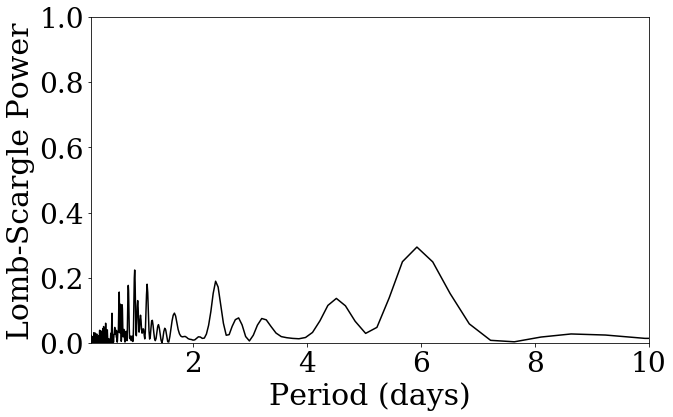

In [151]:



freq, PLS = LombScargle(mjd2, mag2, dmag2).autopower(minimum_frequency=1 / 100.,
                                                maximum_frequency=1 / 0.1)
best_freq = freq[np.argmax(PLS)]
phase = (mjd2 * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1,len(mjd2))
mag_fit = LombScargle(mjd2, mag2, dmag2).model(t=phase_fit / best_freq,
                                          frequency=best_freq)
# plot the periodogram

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(0.2, 10),
          ylim=(0, 1));
ax.set_xlabel('Period (days)',fontsize=30)
ax.set_ylabel('Lomb-Scargle Power',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=28)


plt.plot(1. / freq, PLS,color='k',ls='solid')

plt.show()
#save iamge
fig.savefig('periodogram.eps', format='eps',bbox_inches = "tight")


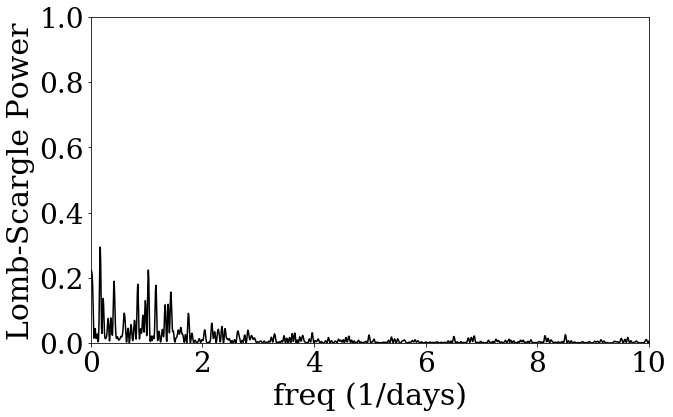

In [156]:



freq, PLS = LombScargle(mjd2, mag2, dmag2).autopower(minimum_frequency=1 / 100.,
                                                maximum_frequency=1 / 0.1)
best_freq = freq[np.argmax(PLS)]
phase = (mjd2 * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1,len(mjd2))
mag_fit = LombScargle(mjd2, mag2, dmag2).model(t=phase_fit / best_freq,
                                          frequency=best_freq)
# plot the periodogram

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(0, 10),
          ylim=(0, 1));
ax.set_xlabel('freq (1/days)',fontsize=30)
ax.set_ylabel('Lomb-Scargle Power',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=28)


plt.plot(freq, PLS,color='k',ls='solid')

plt.show()
#save iamge
fig.savefig('periodogram.eps', format='eps',bbox_inches = "tight")


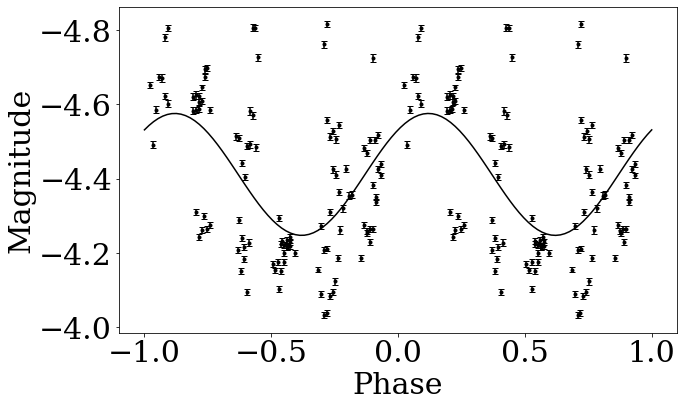

<Figure size 432x288 with 0 Axes>

In [146]:
# plot the periodogram

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')



#Two phases

phase2 = phase-1
phasesall= np.concatenate((phase2, phase), axis=None)
magall = np.concatenate((mag2,mag2),axis=None)
dmagall = np.concatenate((dmag2,dmag2),axis=None)


# compute the best-fit model
phase_fit2 = np.linspace(-1, 1,len(mjd2))
mag_fit2 = LombScargle(mjd2, mag2).model(t=phase_fit2 / best_freq,
                                          frequency=best_freq)




fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1, 1, 1)
ax.invert_yaxis()


ax.set_xlabel('Phase',fontsize=30)
ax.set_ylabel('Magnitude',fontsize=30)


plt.plot(phase_fit2, mag_fit2,color='k',ls='solid')
ax.errorbar(phasesall, magall,  dmagall,fmt='.',color='k',capsize=3)

ax.tick_params(axis='both', which='major', labelsize=30)

plt.show()
plt.tight_layout()



#save iamge
fig.savefig('folded.eps', format='eps',bbox_inches = "tight")
fig.savefig('folded.png', format='png',bbox_inches = "tight")
fig.savefig('folded.svg', format='svg',bbox_inches="tight", transparent=True)